In [1]:
from scripts.paths import *
from scripts.gh_dataset import MixedDataset
from scripts.languages_list import BinLabels, Languages
from scripts.languages_list_old import Languages as LanguagesOld
from scripts.gru_model import Network, NetworkConfig

import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import json

In [ ]:
NetworkConfig()

In [2]:
with open(SPLIT_FILE) as fp:
    splits = json.load(fp)

In [3]:
dataset = MixedDataset(mode="langs", split="train_gru")

In [7]:
dataset.is_code[100000]

1

In [8]:
dataset.langs[100000]

20

In [9]:
dataset.files[100000]

PosixPath('data/gh_data/Ruby/aa1b29ca-17d6-45c2-bfbc-0ece7bb7c70e.rb')

In [10]:
splits["files"]

KeyError: 'files'

In [69]:
i = np.random.choice(len(dataset))
text, label = dataset[i]
print(dataset.files[i])
print(Languages(label))
print(text)

data/gh_data/PowerShell/45180670-1d82-470b-a1f6-fb716d0519db.ps1
Languages.POWERSHELL
    }

    if($Credential.UserName -match "\\") {
        $UserName = $Credential.UserName.Split("\")[1]
        $Domain = $Credential.UserName.Split("\")[0]
    }
    else {
        $UserName = $Credential.UserName
    }

    $tokenResult = $WebServiceProxy.Authenticate($UserName, $Credential.GetNetworkCredential().password, '', $Domain)
    
    if($tokenResult.Errors.Count -gt 0) {
        Throw "Authentication Error: $($tokenResult.Errors[0])"
    }

    $token = $tokenResult.Token

    if($passthru) {
        $Token
    }

    if($UpdateSecretConfig) {
        Set-SecretServerConfig -Token $Token
        $SecretServerConfig.Token = $Token
    }
}



In [5]:
with open("data/splits.json") as fp:
    splits = json.load(fp)

In [14]:
from collections import Counter

files = []
langs = []
counts = Counter()

for file, meta in splits["train_gru"].items():
    origin = meta["origin"]
    if origin == "tg":
        files.append(file)
        counts["tg"] += 1
    else:
        lang = meta["lang"]
        if lang not in counts or counts[lang] < 500 or Path(file).suffix == ".txt":
            files.append(file)
            counts[lang] += 1

In [2]:
dataset = BinaryDataset(subsample_lines=True)

files = np.array(dataset.files)
origins = np.array(dataset.origins)
labels = np.array([label.value for label in dataset.labels])

In [29]:
tg_code_files = files[(origins == "tg") & (labels == BinLabels.CODE.value)]

In [45]:
import ctypes
from sys import path
from scripts.languages_list_old import Languages as LanguagesOld

class CTGLang:
    def __init__(self):
        self.lib = ctypes.CDLL("old_model/libtglang.so")
        self.lib.tglang_detect_programming_language.argtypes = [ctypes.c_char_p]
        self.lib.tglang_detect_programming_language.restype = ctypes.c_int

    def __call__(self, string):
        return LanguagesOld.to_string(LanguagesOld(self.lib.tglang_detect_programming_language(string.encode())))

In [46]:
old_model = CTGLang()

In [63]:
new_langs = [Languages.to_string(lang) for lang in Languages]

In [64]:
new_langs

['Other',
 'C',
 'C++',
 'C#',
 'CSS',
 'Dart',
 'Docker',
 'FunC',
 'Go',
 'HTML',
 'Java',
 'JavaScript',
 'JSON',
 'Kotlin',
 'Lua',
 'NGINX',
 'Objective-C',
 'PHP',
 'PowerShell',
 'Python',
 'Ruby',
 'Rust',
 'Shell',
 'Solidity',
 'SQL',
 'Swift',
 'TL',
 'TypeScript',
 'XML']

In [83]:
files_list = {
    file.as_posix(): {
        "origin": origin,
        "is_code": bool(label == BinLabels.CODE.value),
        "lang": file.parent.name if origin == "gh" else None
    }
    for file, origin, label in zip(files, origins, labels)
}

In [ ]:
other_code_files = []

for i, file in enumerate(tg_code_files):
    text = file.read_text()
    prediction = old_model(text)
    
    if prediction not in new_langs and prediction != "Bash":
        other_code_files.append(file)

        files_list[file.as_posix()]["is_code"] = False

In [85]:
import json

with open("data/files.json", mode="w") as fp:
    json.dump(files_list, fp)

In [95]:
files = []
is_code = []
lang = [] 
origins = []

for file, meta in files_list.items():
    files.append(file)
    is_code.append(meta["is_code"])
    lang.append(meta["lang"])
    origins.append(meta["origin"])

files = np.array(files)
is_code = np.array(is_code)
lang = np.array(lang)
origins = np.array(origins)

In [96]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(np.arange(len(files)), test_size=.2,
                               stratify=list(zip(is_code, lang, origins)), random_state=42)

train_gru, train_svc = train_test_split(train, test_size=.1,
                                        stratify=list(zip(is_code[train], lang[train], origins[train])), random_state=42)

In [102]:
splits = {
    "train_gru": {
        str(file): {
            "origin": str(origin),
            "is_code": bool(is_code),
            "lang": lang,
        }
        for file, origin, is_code, lang in zip(files[train_gru], origins[train_gru], is_code[train_gru], lang[train_gru])
    },
    "train_svc": {
        str(file): {
            "origin": str(origin),
            "is_code": bool(is_code),
            "lang": lang
        }
        for file, origin, is_code, lang in zip(files[train_svc], origins[train_svc], is_code[train_svc], lang[train_svc])
    },
    "test": {
        str(file): {
            "origin": str(origin),
            "is_code": bool(is_code),
            "lang": lang
        }
        for file, origin, is_code, lang in zip(files[test], origins[test], is_code[test], lang[test])
    },
}

In [103]:
with open("data/splits.json", "w") as fp:
    json.dump(splits, fp)

In [3]:
idxs = np.arange(len(dataset))
np.random.shuffle(idxs)

lengths = []

for i, idx in enumerate(idxs):
    text, label = dataset[idx]
    
    lengths.append(len(text))
    # print(text)
    # print("="*100)

    if i == 50000:
        break

In [5]:
tg_files = files[origins == "tg"]
gh_files = np.random.choice(files[origins == "gh"], 50000)

In [6]:
def calc_statistics(files):
    num_lines = []
    line_lengths = []
    num_symbols = []

    for file in tqdm(files):
        file: Path
        text = file.read_text()

        lines = text.split("\n")
        num_lines.append(len(lines))
        line_lengths.extend(len(line) for line in lines)
        num_symbols.append(len(text))

    num_lines = np.array(num_lines)
    line_lengths = np.array(line_lengths)
    num_symbols = np.array(num_symbols)

    return num_lines, line_lengths, num_symbols

tg_num_lines, tg_line_lengths, tg_num_symbols = calc_statistics(tg_files)
# gh_num_lines, gh_line_lengths, gh_num_symbols = calc_statistics(gh_files)

  0%|          | 0/21738 [00:00<?, ?it/s]

In [7]:
import numpy as np
from scipy.optimize import minimize

# Define the log logistic probability density function
def log_logistic_pdf(x, alpha, beta):
    return (beta / alpha) * ((x / alpha) ** (beta - 1)) / (1 + (x / alpha) ** beta) ** 2

# Define the negative log-likelihood function for the log logistic distribution
def negative_log_likelihood(params, data):
    alpha, beta = params
    log_likelihood = np.sum(np.log(log_logistic_pdf(data, alpha, beta)))
    return -log_likelihood

np.random.seed(42)

# Initial guess for parameters
initial_guess = [np.median(tg_num_symbols), 0.5]

# Use the minimize function to find the MLE parameters
result = minimize(negative_log_likelihood, initial_guess, args=(tg_num_symbols[tg_num_symbols != 89],), method='Nelder-Mead')

# Extract the optimal parameters
optimal_alpha, optimal_beta = result.x

# Print the results
print(f"Optimal alpha: {optimal_alpha}")
print(f"Optimal beta: {optimal_beta}")

Optimal alpha: 70.53031203267946
Optimal beta: 1.2777589461265924


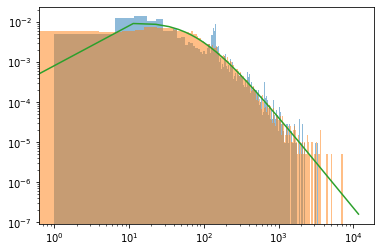

In [11]:
a = optimal_alpha #np.median(tg_num_symbols)
b = optimal_beta

plt.hist(tg_num_symbols[tg_num_symbols != 89], density=True, bins=2048, alpha=0.5);
plt.hist(lengths, density=True, bins=2048, alpha=0.5)
x0, x1 = plt.xlim()
xx = np.linspace(0, x1, 1024)
plt.plot(xx, (b / a) * (xx / a)**(b - 1) / (1 + (xx / a)**b)**2) # * np.exp(-lmb * xx)
plt.xscale("log")
plt.yscale("log")
# plt.xlim(1, 1000)

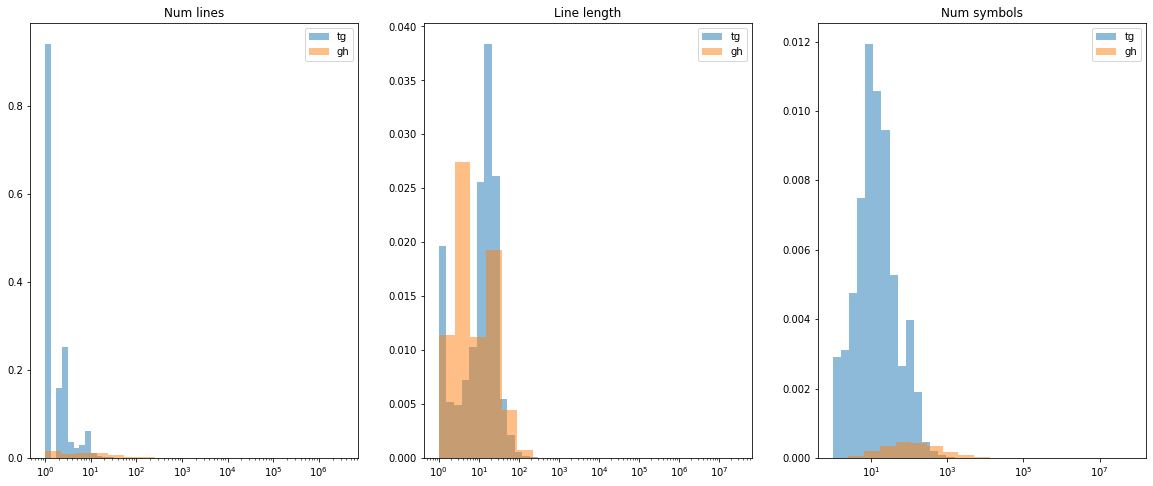

In [28]:
plt.figure(figsize=[20, 8])

logbins = lambda x: np.logspace(np.log10(max(x.min(), 1)),
                                np.log10(x.max()), 20)

plt.subplot(131)
plt.hist(tg_num_lines, bins=logbins(tg_num_lines), density=True, alpha=0.5, label="tg");
plt.hist(gh_num_lines, bins=logbins(gh_num_lines), density=True, alpha=0.5, label="gh");
plt.legend()
plt.title("Num lines")
plt.xscale("log")
# plt.yscale("log")

plt.subplot(132)
plt.hist(tg_line_lengths, bins=logbins(tg_line_lengths), density=True, alpha=0.5, label="tg");
plt.hist(gh_line_lengths, bins=logbins(gh_line_lengths), density=True, alpha=0.5, label="gh");
plt.legend()
plt.title("Line length")
plt.xscale("log")
# plt.yscale("log")

plt.subplot(133)
plt.hist(tg_num_symbols, bins=logbins(tg_num_symbols), density=True, alpha=0.5, label="tg");
plt.hist(gh_num_symbols, bins=logbins(gh_num_symbols), density=True, alpha=0.5, label="gh");
plt.legend()
plt.title("Num symbols")
plt.xscale("log")
# plt.yscale("log")

In [7]:
plt.hist(num_lines, bins=128);
plt.yscale("log")
sum(1 - label.value for label in dataset.labels)

688431

<BarContainer object of 2 artists>

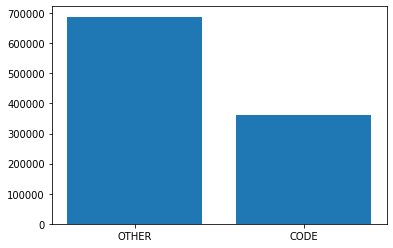

In [6]:
from collections import Counter
counts = Counter([BinLabels.to_string(label) for label in dataset.labels])

plt.bar(counts.keys(), counts.values())

In [5]:
len(dataset)

1050298

In [24]:
test

array([346856, 934576, 829196, ..., 938547, 519809, 553126])

In [ ]:
files = np.array(dataset.files)
labels = np.array(dataset.labels)

In [9]:
bad_files = []

for file, label in zip(tqdm(dataset.files), dataset.labels):
    text = file.read_text()
    lines = text.split("\n")

    if len(text.strip()) == 0 or len(lines) == 0:
        bad_files.append(file)
        continue

    max_line_len = max(len(line) for line in lines)
    
    if max_line_len > 200 and label == BinLabels.CODE.value:
        bad_files.append(file)

  0%|          | 0/1050298 [00:00<?, ?it/s]

In [14]:
func_dir = DATA / "gh_data/FunC"

files = sorted(func_dir.glob("*"))

In [15]:
to_delete = []

for file in files:
    content = file.read_text().strip()
    lines = content.split("\n")

    if any(line.startswith("/") for line in lines):
        to_delete.append(file)